In [1]:
from y0.examples import *

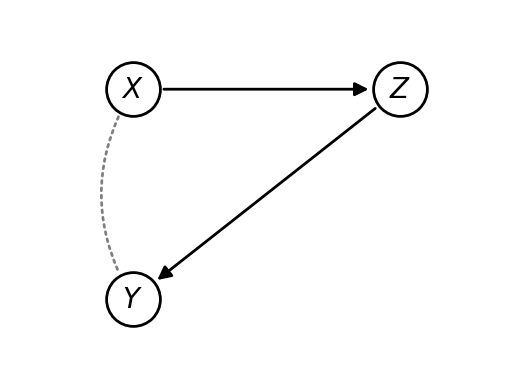

In [2]:
frontdoor_example.graph.draw()

In [3]:
frontdoor_example.graph.to_linear_scm_latex()

'\\begin{align*}X &= \\epsilon_{X} + \\gamma_{X,Y} \\\\\n Z &= X \\beta_{X,Z} + \\epsilon_{Z} \\\\\n Y &= Z \\beta_{Z,Y} + \\epsilon_{Y} + \\gamma_{X,Y} \\\\\\end{align*}'

In [16]:
X.to_sympy()

X

In [13]:
sp = frontdoor_example.graph.to_linear_scm_sympy()
sp[X]

\epsilon_{X} + \gamma_{X,Y}

In [11]:
import sympytorch
import sympy
from sympy import solve, Eq

In [6]:
names, expressions = zip(*sorted(sp.items()))
names, expressions

((X, Y, Z),
 (\epsilon_{X} + \gamma_{X,Y},
  Z*\beta_{Z,Y} + \epsilon_{Y} + \gamma_{X,Y},
  X*\beta_{X,Z} + \epsilon_{Z}))

In [80]:
import torch

n = 1
epsilon_x = torch.rand(n)
epsilon_y = torch.rand(n)
epsilon_z = torch.rand(n)
gamma_xy = torch.rand(n)
beta_zy = torch.rand(n)
beta_xz = torch.rand(n)

In [81]:
torch_params = {
    r"\epsilon_{X}": epsilon_x,
    r"\epsilon_{Y}": epsilon_y,
    r"\epsilon_{Z}": epsilon_z,
    r"\gamma_{X,Y}": gamma_xy,
    r"\beta_{Z,Y}": beta_zy,
    r"\beta_{X,Z}": beta_xz,
}
params = {
    r"\epsilon_{X}": epsilon_x.detach().cpu().numpy().squeeze(),
    r"\epsilon_{Y}": epsilon_y.detach().cpu().numpy().squeeze(),
    r"\epsilon_{Z}": epsilon_z.detach().cpu().numpy().squeeze(),
    r"\gamma_{X,Y}": gamma_xy.detach().cpu().numpy().squeeze(),
    r"\beta_{Z,Y}": beta_zy.detach().cpu().numpy().squeeze(),
    r"\beta_{X,Z}": beta_xz.detach().cpu().numpy().squeeze(),
}

In [33]:
torch.rand(3).squeeze()

tensor([0.3543, 0.6550, 0.2555])

In [82]:
import numpy as np

eqns = [Eq(lhs.to_sympy(), rhs.subs(params)) for lhs, rhs in sp.items()]
eqns

[Eq(X, 0.986932694911957),
 Eq(Z, 0.879730999469757*X + 0.751361310482025),
 Eq(Y, 0.605754375457764*Z + 1.14167708158493)]

In [20]:
type(names[0])

y0.dsl.Variable

In [83]:
solution = solve(eqns, [n.to_sympy() for n in names], rational=False)
solution

{X: 0.986932694911957, Y: 2.12275480644359, Z: 1.61959659658630}

In [56]:
[type(float(v)) for v in solution.values()]

[float, float, float]

In [84]:
torch_vars = {str(k): torch.tensor(float(v)) for k, v in solution.items()}
torch_vars

{'X': tensor(0.9869), 'Y': tensor(2.1228), 'Z': tensor(1.6196)}

In [85]:
mod = sympytorch.SymPyModule(expressions=expressions)

scm_torch_vars = mod(**torch_params, **torch_vars)
scm_torch_vars

tensor([[0.9869, 2.1228, 1.6196]])

In [78]:
torch_vars

{'X': tensor(0.8365), 'Y': tensor(1.4070), 'Z': tensor(0.8581)}

Z*\beta_{Z,Y} + \epsilon_{Y} + \gamma_{X,Y}

In [87]:
assert (
    scm_torch_vars[0][1]
    == torch_vars["Z"] * torch_params[r"\beta_{Z,Y}"]
    + torch_params[r"\epsilon_{Y}"]
    + torch_params[r"\gamma_{X,Y}"]
)

X*\beta_{X,Z} + \epsilon_{Z}

In [88]:
assert (
    scm_torch_vars[0][2]
    == torch_vars["X"] * torch_params[r"\beta_{X,Z}"] + torch_params[r"\epsilon_{Z}"]
)

In [86]:
assert scm_torch_vars[0][0] == torch_params["\\epsilon_{X}"] + torch_params["\\gamma_{X,Y}"]

# Pyro single door 

In Pyro, you would often use a probabilistic programming approach to define your model using distributions for both data and parameters. The objective is usually to infer the values of the learnable parameters that explain the observed data. When translating the provided deterministic function to a Pyro model, it requires a bit of reinterpretation since Pyro operates on a different paradigm. Below is a Pyro translation that adheres to the spirit of your function:

In [90]:
import pyro
import pyro.distributions as dist
import torch
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
import pandas as pd
from networkx import NetworkXNotImplemented
from pyro.contrib.autoguide import AutoDiagonalNormal

def pyro_single_door_learnable(graph, data):
    """
    Pyro model to estimate parameter values for a linear SCM using backdoor adjustment.
    Observe data as noisy observations of state variables, which are functions of learnable parameters.
    """

    # Convert the pandas dataframe to a tensor for use with Pyro
    data_tensor = torch.tensor(data.values, dtype=torch.float32)
    num_obs, num_vars = data_tensor.shape

    # Define a guide for our parameters (here, an AutoDiagonalNormal -- a form of automatic variational inference)
    # We'll have as many latent variables as there are edges in the graph
    num_params = len(graph.directed.edges)
    guide = AutoDiagonalNormal(lambda: pyro.param("coefs", torch.zeros(num_params)))

    # Prepare a dictionary to collect parameter values
    estimated_params = {}

    # The model
    def model():
        # Iterate over each edge in the graph as before
        priors = {node: pyro.sample(f"prior_{str(node)}", dist.Normal(0., 1.)) for node in graph]

        for source, target in graph.directed.edges():

            # Check for NetworkXNotImplemented error to adhere to pyro's exception handling
            try:
                adjustment_sets = graph.to_pgmpy_causal_inference().get_all_backdoor_adjustment_sets(
                    source.name, target.name)
            except ValueError or NetworkXNotImplemented:
                continue  # Skip if no valid backdoor adjustment sets

            if not adjustment_sets:
                continue  # Skip if no valid backdoor adjustment sets
            
            adjustment_set = list(adjustment_sets)[0]
            variables = sorted(adjustment_set | {source.name})
            idx = variables.index(source.name)

            # Define a learnable parameter for the coefficient of the source variable
            coef = pyro.param(f"coef_{source.name}_to_{target.name}", torch.tensor(0.0))
            # Specify priors on other variables

            # Observations based on the linear combination of variables
            mean = coef * data_tensor[:, idx] + torch.tensor(priors).sum(axis=0)
            with pyro.plate(f"data_plate_{source.name}_{target.name}", size=num_obs, dim=-1):
                # Observe the data
                pyro.sample(
                    f"obs_{source.name}_{target.name}",
                    dist.Normal(mean, 1.0),  # Assuming noise of 1.0 for simplicity
                    obs=data_tensor[:, data.columns.get_loc(target.name)]
                )
                
            # Keep estimated parameters in a dictionary
            estimated_params[(source, target)] = coef.item()

    # Setup optimization
    adam = Adam({"lr": 0.01})
    svi = SVI(model=model, guide=guide, optim=adam, loss=Trace_ELBO())

    # Run optimization/learning
    num_iterations = 1000  # Set an appropriate number of iterations
    for _ in range(num_iterations):
        svi.step()

    # Return the learned coefficients
    return estimated_params
    

In this translation:
1. We define a Pyro model that observes data and estimates the coefficient for the `source` variable that corresponds to the linear regression coefficient.
2. We parametrize the coefficients for each edge in the graph and use Pyro's SVI (Stochastic Variational Inference) for optimization.
3. An `AutoDiagonalNormal` guide is used, which is a simple but often effective choice for variational inference with continuous latent variables.
4. Pyro plates are used to handle vectorized observations for the target variable.
5. The learned parameters are stored in a dictionary, similar to the original specification.

Note that in a real application, you would need to choose appropriate priors based on your domain knowledge and likely need to adjust aspects of the guide and inference for the model to fit well. This translation is not exact but provides a structure to build upon using Pyro's methodology.